In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf

### **Difference-in-Difference**

#### **The experimental ideal**

- We can randomly assign experimental units to treatment - control -> manage selection bias
- conditional independence assumption holds
- issues for inference: heteroskedasticity and clustering

#### **The 'quasi-experimental' setting**
- Based on the parallel trend assumption:

    *In the absence of treatment, the difference between the treated and control groups would have remained the same over time*

- Simply taking differences between control and treatment, or between pre- and post-treatment, doesn't work:
    - Control vs. treatment: We may have **ommited variable bias**, even after controlling by other factors via OLS (i.e., observing additional variables to correct for them in the model)
    - Pre- vs. post-treatment: As above, evolution can be due to other factors.
    
- **Fundamental problem of causal inference**: we cannot observe the evolution the treatment group would have had without treatment, so we don't have an direct counterfactual. DiD tries to approximate this.

#### **Main idea of DiD**
- Treatment and control groups have similar evolution pre-treatment and this extends to the post-treatment period.
- In other words, observed and unobserved differences between control and treatment remain constant
- This way, all the change in the treatment group post-treatment is attributable to the treatment
- Then, we can:
    - Take difference after - before treatment in each group (control and treatment) -> removes the temporal trend in each group (**as long as it's the same in control and treatment, see assumption above**)
    - Take the difference between control and treatment group at each time (before and after treatment) -> removes the constant (**assumed!**) difference between them
    - Take the difference between these two differences: **if assumtion holds**, the remaining difference is the **treatment effect**

Graph below illustrates this point:

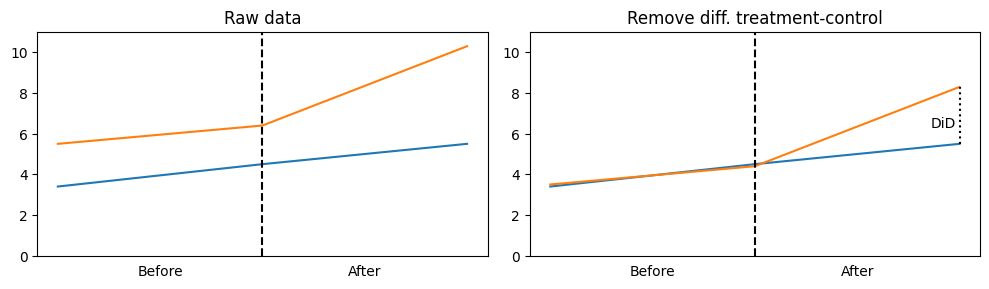

In [199]:
df = pd.DataFrame({'index': [0, 0.5, 1], 'control': [3.4, 4.5, 5.5], 'treatment': [5.5, 6.4, 10.3]}).set_index('index')

def make_subplot(ax, title, time, treatment, control):
    ax.set_title(title)
    ax.plot(time, control, label='control')
    ax.plot(time, treatment, label='treatment')
    ax.axvline(0.5, c='black', linestyle='--')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(0, 11)
    ax.text(0.25, -1, 'Before', fontsize=10, ha='center')
    ax.text(0.75, -1, 'After', fontsize=10, ha='center')

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
make_subplot(ax[0], 'Raw data', df.index, df['treatment'], df['control'])
make_subplot(ax[1], 'Remove diff. treatment-control', df.index, df['treatment'] - 2, df['control'])
ax[1].vlines(x=df.index[-1], ymin=5.5, ymax=8.3, linestyle=':', color='black')
ax[1].text(0.93, 6.3, 'DiD', fontsize=10, ha='left')
plt.tight_layout()
plt.show()

### How to check parallel trends assumption?
- Visual inspection
- Placebo effect: run DiD for time periods before treatment and see if you find an effect
- Synthetic control: build a weighted combination of control units that closely resembles the pre-treatment trend of the treatment group 

### **The math**

The DiD model consists of the following elements:
- $Y_{it}$ = outcome for group $i$ (treatment or control) at time $t$
- $T_i$ = treatment indicator, 1 if treatment, 0 if not
- $P_t$ = time indicator, 0 before treatment, 1 after

> Model: $Y_{it} = \beta_0 + \beta_1T_i + \beta_2P_t + \beta_3(T_i \times P_t) + \alpha_i + \lambda_t + \epsilon_{it}$

- Elements:
    - $\beta_0$ = baseline outcome, i.e., $Y_{it}$ before treatment in control group
    - $\beta_1 $ = effect of difference between groups before treatment 
    - $\beta_2 $ = effect of time trends in both groups
    - $\beta_3$ = **DiD estimator**
    - $\alpha_i$ = unit-fixed effects (time-invariant unit-specific differences)
    - $\lambda_t$ = time-fixed effects (time-trend common to all units)
    - $\epsilon_{it}$ = random error with mean $\mu=0$ and variance $\sigma$

The model can also include new or exclude some of the above elements. For instance, we could include a global linear trend to absorb a common trend across all units, or a fixed-effect coefficients for absorbing a constant differences across units, and so on.

#### Expected values before/after/control/treatment

- Before treatment, control group: 
    - $E[Y_{it}|P_t = 0, T_i = 0] = E[\beta_0 + \beta_1T_i + \beta_2P_t + \beta_3(T_i \times P_t) + \epsilon_{it}]$ 
    - $E[Y_{it}|P_t = 0, T_i = 0] = \beta_0$
- Before treatment, treatment group: 
    - $E[Y_{it}|P_t = 0, T_i = 1] = \beta_0 + \beta_1$
- After treatment, control group: 
    - $E[Y_{it}|P_t = 1, T_i = 0] = \beta_0 + \beta_2$
- After treatment, treatment group: 
    - $E[Y_{it}|P_t = 1, T_i = 1] = \beta_0 + \beta_1 + \beta_2 + \beta_3$


### **An example with synthetic data**

Create indexes for the data: 200 experimental units - 100 for control and 100 for treatment; 10 timesteps for each unit in each group, i.e., 2000 datapoints in total

In [200]:
np.random.seed(42)

n_times = 10  # n periods
n_units = 100  # n units per group

# t=0 ... t=9 for each unit in each group, i.e., n = 10 (times) x 2 (groups) x n_units
time_periods = np.tile(np.arange(n_times), n_units * 2) 

# repeat 'control' n_time x n_units times, then same for 'treatment'  
group = np.repeat(['control', 'treatment'], n_units * n_times)  

# repeat same unit_id n_time times, same for all unit ids, then the whole thing 2 times (control, treatment)
unit_id = np.tile(np.repeat(np.arange(n_units), n_times), 2) 

Make common trend across all units in both groups: $\text{intercept} + \text{slope}\times t + \epsilon$, with $\epsilon$ = normal random noise with mean $\mu = 0$ and standard deviation $\sigma$. Also, to that common trend (base outcome), add a treatment effect of 5 to make the total value of the response variable:

In [201]:
# make control -> base outcome is function of time (slope = 2) + normal random noise with miu=0 and sigma=1.3
intercept = 10
slope = 2
base_outcome = intercept + slope*time_periods + np.random.normal(0, 1.3, size=len(time_periods))

# make treatment effect -> starts at t=5, obviously only for treatment units
treatment_effect = (time_periods >= 5)*(group == 'treatment') * 5

# outcome (observed values) = base + treatment
outcome = base_outcome + treatment_effect

# Create a DataFrame
df = pd.DataFrame({
    'unit_id': unit_id,
    'time': time_periods,
    'group': group,
    'outcome': outcome
})

df.head(5)

,unit_id,time,group,outcome
0,0,0,control,10.645728
1,0,1,control,11.820256
2,0,2,control,14.841995
3,0,3,control,17.979939
4,0,4,control,17.695601


Plot dataset:

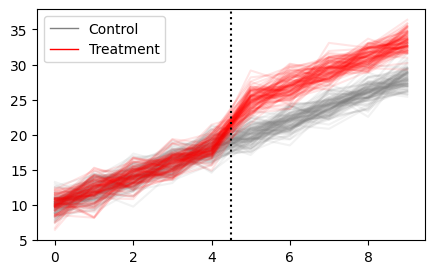

In [202]:
fig, ax = plt.subplots(figsize=(5, 3))
for i in range(0, 2000, 10):
    color = 'gray' if i<1000 else 'red'
    ax.plot(outcome[i : (i + 10)], color=color, alpha=0.1)
ax.axvline(x=4.5, linestyle=':', color='black')
legend_elements = [
    Line2D([0], [0], color='gray', lw=1, label='Control'),
    Line2D([0], [0], color='red', lw=1, label='Treatment')
]
ax.legend(handles=legend_elements)
plt.show()

In [203]:
# create DiD variables
df['post'] = (df['time'] >= 5).astype(int)  # 1 if post-treatment, 0 otherwise
df['treatment'] = (df['group'] == 'treatment').astype(int)  # 1 if treatment, 0 otherwise
df['interaction'] = df['treatment'] * df['post']  # Interaction term

Use a simple OLS model to test for treatment effects. The model must include a temporal trend:

$Y_{it} = \beta_0 + \beta_1t_t + \beta_2T_{i} + \beta_3P_t + \beta_4(T_i \times P_t) + \epsilon_{it}$

In [204]:
# DiD regression
model = smf.ols("outcome ~ time + treatment + post + interaction", data=df).fit()

# Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.533e+04
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:40:15   Log-Likelihood:                -3335.8
No. Observations:                2000   AIC:                             6682.
Df Residuals:                    1995   BIC:                             6710.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.9500      0.070    141.447      

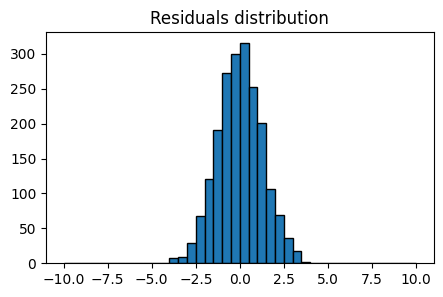

In [205]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_title('Residuals distribution')
ax.hist(model.resid, bins=np.arange(-10, 10.5, 0.5), edgecolor='black')
plt.show()

Residuals are normally distributed, which can be seen graphically and also in the results of the Jarque-Bera and Omnibus tests.

Treatment effects are statistically significant $P(|t|) > 0.000$ and the effect size is close to the value we specified when created the synthetic data ($\text{interaction} = 5.0273 \pm 0.115$, $t = 43.76$).